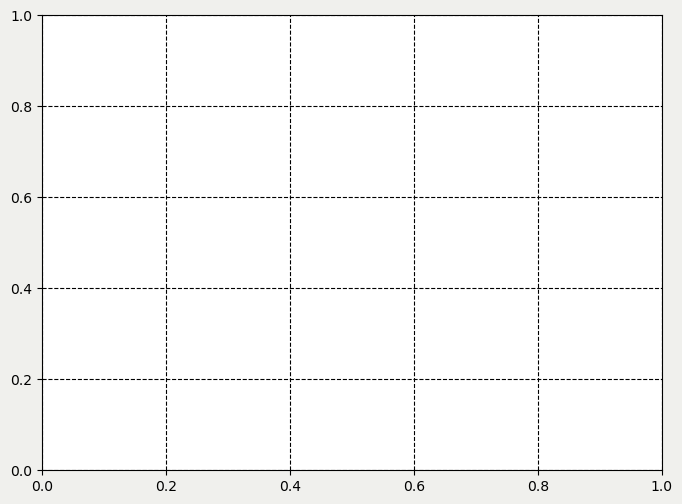

In [3]:

## NOMBRE COMPLETO: RENZO EDMUNDO REYMUNDO RAMOS
## CODIGO: U202119710
## SECCION: LS6B
import tkinter as tk
import tkinter.ttk as ttk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import yfinance as yf
import mplfinance as mpf
import requests

class CryptoMonitor(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Crypto Monitor")
        self.geometry("1270x650+100+100")

        self.DictTokens = {
            "Bitcoin": "https://api.coinbase.com/v2/prices/btc-usdt/spot",
            "Ethereum": "https://api.coinbase.com/v2/prices/eth-usd/spot",
            "Chainlink": "https://api.coinbase.com/v2/prices/link-usd/spot",
            "Binance Coin": "https://api.coinbase.com/v2/prices/bnb-usd/spot",
            "Litecoin": "https://api.coinbase.com/v2/prices/ltc-usd/spot",
            "Dogecoin": "https://api.coinbase.com/v2/prices/doge-usd/spot"}

        self.ValorActualToken = 0
        self.ValorAnteriorToken = 0
        self.TokenSigla = ""
        self.TokenSeleccionado = ""
        self.DFToken = pd.DataFrame()
        self.LastClosePrice = 0
        self.PrecioMinimoHistorico = 0
        self.PrecioMaximoHistorico = 0
        self.kwargs = dict(type='candle', figratio=(6.9, 6), figscale=1.2)

        self.mc = mpf.make_marketcolors(up='g', down='r')
        self.s = mpf.make_mpf_style(marketcolors=self.mc, figcolor="#F0F0ED", gridcolor='black', gridstyle='dashed')

        frm = tk.Frame(self)
        frm.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        self.lblfrm_PriceRealtime = tk.LabelFrame(frm, text="Price Realtime")
        self.lblfrm_HistoricData = tk.LabelFrame(frm, text="Historic Data")
        self.lblfrm_PriceHistoric = tk.LabelFrame(frm, text="Price Historic Chart")
        self.lblfrm_PriceHistoric.pack(side=tk.RIGHT, padx=10, pady=10)
        self.lblfrm_PriceRealtime.pack(side=tk.LEFT, padx=10, pady=10, fill=tk.BOTH, expand=True)
        self.lblfrm_HistoricData.pack(side=tk.LEFT, padx=10, pady=10, fill=tk.BOTH, expand=True)

        lbl_SelectToken = tk.Label(self.lblfrm_PriceRealtime, text="Select Token:")
        lbl_SelectToken.grid(row=0, column=0, padx=5, pady=5)

        self.ComboToken = ttk.Combobox(self.lblfrm_PriceRealtime, state='readonly', values=list(self.DictTokens.keys()))
        self.ComboToken.grid(row=0, column=1, padx=5, pady=5)
        self.ComboToken.bind("<<ComboboxSelected>>", self.MostrarSeleccion)

        self.lbl_ActualPrice = tk.Label(self.lblfrm_PriceRealtime, text="")
        self.lbl_ActualPrice.grid(row=1, column=0, columnspan=2, padx=5, pady=5)

        self.lbl_MontoCambio = tk.Label(self.lblfrm_PriceRealtime, text="")
        self.lbl_MontoCambio.grid(row=2, column=0, columnspan=2, padx=5, pady=5)

        self.lbl_PorcentajeCambio = tk.Label(self.lblfrm_PriceRealtime, text="")
        self.lbl_PorcentajeCambio.grid(row=3, column=0, columnspan=2, padx=5, pady=5)

        self.HistoricTable = ttk.Treeview(self.lblfrm_HistoricData, columns=(1, 2), height=24)
        self.scrY = tk.Scrollbar(self.lblfrm_HistoricData, orient='vertical')
        self.scrY.config(command=self.HistoricTable.yview)
        self.HistoricTable.configure(yscrollcommand=self.scrY.set)
        self.HistoricTable.pack(side=tk.LEFT)
        self.scrY.pack(side=tk.LEFT, fill=tk.Y)

        self.HistoricTable.heading("#0", text="Date")
        self.HistoricTable.heading("#1", text="Open")
        self.HistoricTable.heading("#2", text="Close")

        self.HistoricTable.column("#0", width=140, minwidth=140, stretch=tk.NO)
        self.HistoricTable.column("#1", width=120, minwidth=120, stretch=tk.NO, anchor=tk.E)
        self.HistoricTable.column("#2", width=120, minwidth=120, stretch=tk.NO, anchor=tk.E)

        self.HistoricTable.tag_configure('even', background='#ffffff')
        self.HistoricTable.tag_configure('odd', background='#808080')

        self.fig, self.ax = plt.subplots(figsize=(8, 6), facecolor="#F0F0ED")
        self.ax.set_fc("white")
        self.ax.grid(linestyle='dashed', color="black")
        self.graph = FigureCanvasTkAgg(self.fig, master=self.lblfrm_PriceHistoric)
        self.graph.get_tk_widget().pack()
        
    def MostrarSeleccion(self,event=None):
        if event:
            print('el evento es:',event)
            self.TokenSeleccionado=self.ComboToken.get()
            self.Actualizar_PriceRealtime(0)
            self.Actualizar_HistoricData(self.TokenSigla)
            self.Actualizar_PriceRealtime(2)
            self.Actualizar_PriceHistoric(self.TokenSeleccionado)
    
    def Actualizar_HistoricData(self,token):
        token_data = yf.Ticker(token + "-USD")
        data = token_data.history(period='1mo')
        self.DFToken = data.loc[:,('Open','High','Low','Close','Volume')]
        data = data.loc[:,('Open','Close')]
        self.PrecioMaximoHistorico = max(data.max())
        self.PrecioMinimoHistorico = min(data.min())
        data = data.round(decimals=2)
        self.LastClosePrice=data['Close'][-1]
       
        #data = data.style.format(precision=2)
        for i in self.HistoricTable.get_children():
            self.HistoricTable.delete(i)
        
        for idx, item in enumerate(data.itertuples()):
            contenido = list(item)
            if idx % 2 == 0:
                tag = 'even'
            else:
                tag = 'odd'
            self.HistoricTable.insert("", tk.END, text=str(contenido[0]).split()[0], values=contenido[1:], tags=(tag,))

        self.apply_tags()
  #obtiene los datos del token y tambien actualiza el precio en tiempo real

    def Actualizar_PriceRealtime(self,ejecucion=1):
        if self.TokenSeleccionado == "":
            #print("esperando")
            self.after(5000, self.Actualizar_PriceRealtime)
            return
        URL = self.DictTokens[self.TokenSeleccionado]
        r = requests.get(URL)
        if r.status_code == requests.codes.ok:
            data = r.json()
            
            if ejecucion == 0:
                self.TokenSigla = data["data"]["base"]
                #print('el valor de self.TokenSigla = data["data"]["base"] es:',self.TokenSigla)
                
            elif ejecucion == 1:
                
                self.ValorAnteriorToken = self.ValorActualToken
                self.ValorActualToken = float(data["data"]["amount"])
                #print('el valor de data["data"]["amount"] es:', self.ValorActualToken, self.TokenSigla)
                
                self.Calculo_Valores_Labels()
                #print(self.DFToken)
                
                self.after(5000, self.Actualizar_PriceRealtime)
                
            elif ejecucion==2:
                self.ValorAnteriorToken = self.ValorActualToken
                self.ValorActualToken = float(data["data"]["amount"])
                print('el valor de data["data"]["amount"] es:', self.ValorActualToken, self.TokenSigla)
                
                self.Calculo_Valores_Labels()
                
            #falta agregar el valor a los labels
    def Actualizar_PriceHistoric(self, token):
        self.graph.get_tk_widget().destroy()
        self.fig, self.ax = mpf.plot(self.DFToken, returnfig=True, **self.kwargs, style=self.s, title=f'{self.TokenSeleccionado} Historic Price')
        self.graph = FigureCanvasTkAgg(self.fig, master=self.lblfrm_PriceHistoric)
        self.graph.get_tk_widget().pack()
        

    
    def Calculo_Valores_Labels(self):
        if self.ValorActualToken >= self.ValorAnteriorToken:
            color_precio_actual='green'
        else:
            color_precio_actual='red'
        self.lbl_ActualPrice.config(text=f"{self.ValorActualToken:.2f} USD",fg=color_precio_actual,font=("Arial",16))
        
        if self.ValorActualToken >= self.LastClosePrice:
            color_variacion_last_close='green'
        else:
            color_variacion_last_close='red'
        DifNum_valores=self.ValorActualToken-self.LastClosePrice
        DifPorc_valores=((DifNum_valores/self.LastClosePrice)*100).round(decimals=2)
    
        self.lbl_MontoCambio.config(text=f"{DifNum_valores:+.2f}",fg=color_variacion_last_close)
        self.lbl_PorcentajeCambio.config(text=f"{DifPorc_valores:+}%",fg=color_variacion_last_close)
    def apply_tags(self):
        children = self.HistoricTable.get_children()
        for index, child in enumerate(children):
            if index % 2 == 0:
                self.HistoricTable.item(child, tags=('even',))
            else:
                self.HistoricTable.item(child, tags=('odd',))
        
def main():
    app = CryptoMonitor()
    app.Actualizar_PriceRealtime()
    app.mainloop()
            
            
            
main()                 